In [12]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import seaborn as sns
import dateparser
import time

In [13]:
def collect_urls(query: str, max_results: int=100):
    q = f"{query} site:kazpravda.kz"
    results = list(search(q, num_results=max_results))
    urls = [u for u in results if "kazpravda.kz" in u]
    return urls[:max_results]

urls = collect_urls("Фонд Булата Утемуратова", max_results=100)
len(urls)

99

In [14]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                     "AppleWebKit/537.36 (KHTML, like Gecko) "
                     "Chrome/114.0.0.0 Safari/537.36")

from selenium.webdriver.chrome.service import Service

service = Service(ChromeDriverManager().install())
driver  = webdriver.Chrome(service=service, options=options)

In [15]:
def parse_article_selenium(url: str):
    driver.get(url)
    time.sleep(2)  
    soup = BeautifulSoup(driver.page_source, "html.parser")

    title_el = soup.select_one("h1.article__title")
    title = title_el.get_text(strip=True) if title_el else None

    date_el = soup.select_one("time.article__date")
    date = date_el.get_text(strip=True) if date_el else None

    views_el = soup.select_one("div.article__views")
    views = views_el.get_text(strip=True).replace(" ", "") if views_el else None

    return {"url": url, "title": title, "date": date, "views": views}

In [16]:
urls = collect_urls("Фонд Булата Утемуратова", max_results=100)
data = [parse_article_selenium(u) for u in urls]
df = pd.DataFrame(data)
df.head(5)

,url,title,date,views
0,https://kazpravda.kz/n/fond-bulata-utemuratova-vydelil-6-mln-dollarov-na-stroitelstvo-150-domov-v-maktaarale/,Фонд Булата Утемуратова выделил 6 млн долларов на строительство 150 домов в Мактаарале,8 мая 2020 г. 12:28,3509
1,https://kazpravda.kz/n/sokrovishcha-velikoy-stepi-predstavili-v-znamenitom-frantsuzskom-muzee-gime/,Сокровища Великой степи представили в знаменитом французском музее Гиме,5 ноября 2024 г. 9:26,1731
2,https://kazpravda.kz/n/autizm-tsentr-otkryli-s-astane/,Аутизм-центр открыли в Астане,31 марта 2023 г. 16:17,1114
3,https://kazpravda.kz/n/art-proekt-ot-fonda-asyl-miras/,Арт-проект от фонда «Асыл Мирас»,2 июня 2015 г. 23:00,740
4,https://kazpravda.kz/n/krupnyy-biznes-okazyvaet-sponsorskuyu-pomoshch-v-ustranenii-posledstviy-pavodka-k-bozumbaev/,Крупный бизнес оказывает помощь в устранении последствий паводка – Бозумбаев,14 мая 2024 г. 14:14,1881


In [17]:
df.to_csv("kazpravda_articles.csv", index=False)
print("Saved to kazpravda_articles.csv")

Saved to kazpravda_articles.csv


In [18]:
import dateparser
import pandas as pd

def parse_ru_date(x):
    if isinstance(x, str):
        return dateparser.parse(x, languages=['ru'])
    return pd.NaT

df['date'] = df['date'].apply(parse_ru_date)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['views'] = pd.to_numeric(df['views'], errors='coerce').fillna(0).astype(int)

df.dtypes

/var/folders/3m/ygq196c16zs4wgq2yzkj4m200000gn/T/ipykernel_10993/88715954.py:6: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  return dateparser.parse(x, languages=['ru'])


url              object
title            object
date     datetime64[ns]
views             int64
dtype: object

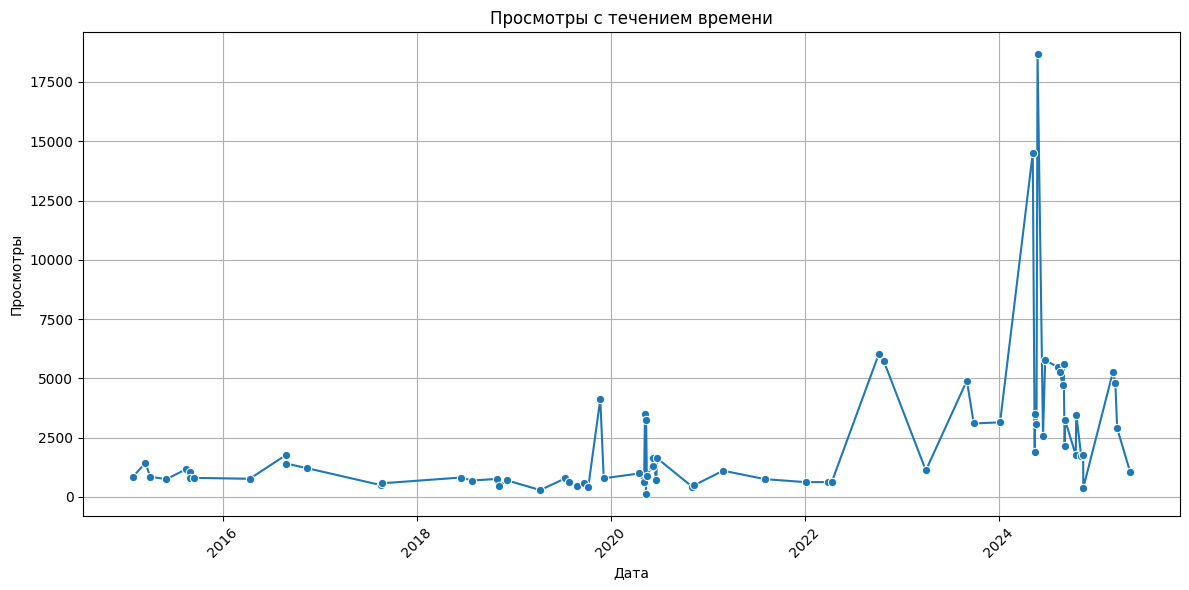

In [19]:
df_sorted = df.sort_values("date")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sorted, x="date", y="views", marker="o")
plt.grid(True)
plt.title("Просмотры с течением времени")
plt.xlabel("Дата")
plt.ylabel("Просмотры")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

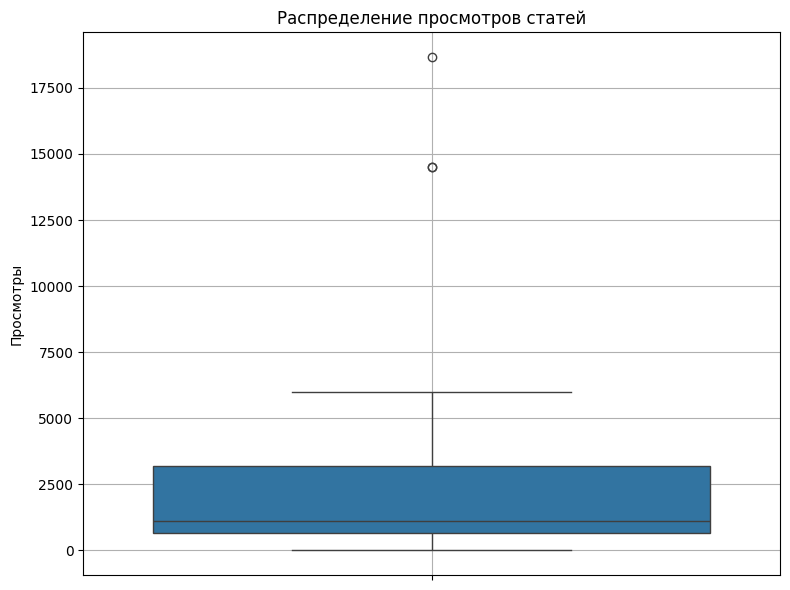

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['views'])
plt.title("Распределение просмотров статей")
plt.ylabel("Просмотры")
plt.tight_layout()
plt.grid(True)
plt.show()

In [21]:
pd.set_option('display.max_colwidth', None)
Q1    = df['views'].quantile(0.25)
Q3    = df['views'].quantile(0.75)
IQR   = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['views'] < lower) | (df['views'] > upper)]
print(f"Number of outliers:{len(outliers)}")
outliers[['title','views']]

Number of outliers:3


,title,views
30,В Косшы открыли первый государственный спортобъект,14492
61,В Косшы вместо «маятниковой» занятости появились постоянные рабочие места,18667
98,В Косшы открыли первый государственный спортобъект,14494


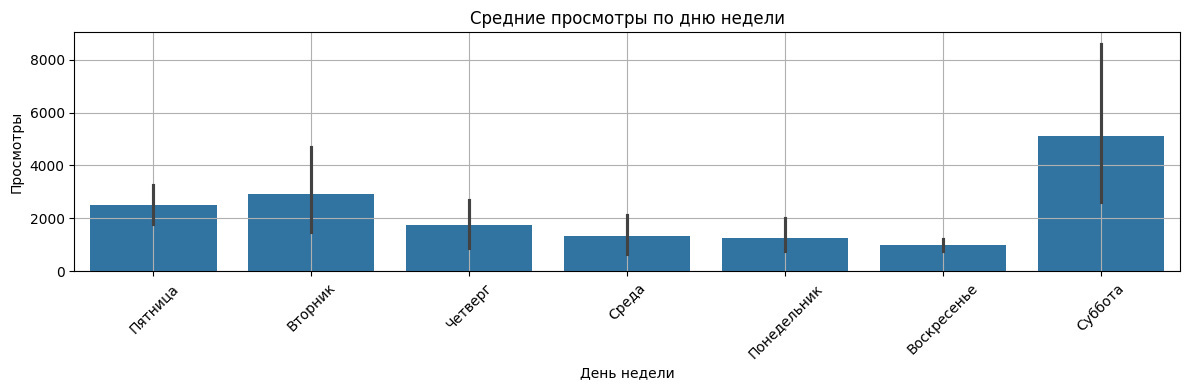

In [22]:
df['dow'] = df['date'].dt.day_name(locale='ru_RU')

plt.figure(figsize=(12, 4))
sns.barplot(
    data=df,
    x='dow',
    y='views',
    estimator='mean', 
)
plt.title("Средние просмотры по дню недели")
plt.xlabel("День недели")
plt.ylabel("Просмотры")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()